In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# South Korea Coronavirus Dataset EDA
data source: https://www.kaggle.com/kimjihoo/coronavirusdataset

In [2]:
Case = pd.read_csv('Case.csv')
PatientInfo = pd.read_csv('PatientInfo.csv')
Policy = pd.read_csv('Policy.csv')
Region = pd.read_csv('Region.csv')
SearchTrend = pd.read_csv('SearchTrend.csv')
SeoulFloating = pd.read_csv('SeoulFloating.csv')
Time = pd.read_csv('Time.csv')
TimeAge = pd.read_csv('TimeAge.csv')
TimeGender = pd.read_csv('TimeGender.csv')
TimeProvince = pd.read_csv('TimeProvince.csv')
Weather = pd.read_csv('Weather.csv')

# Age VS Confirmed cases

At first, I wanted to see which age group has the most confirmed cases.
So I created a simple bar chart that shows the accumulated confirmed cases in different age groups.

Text(0.5, 1.0, 'Accumulated confirmed case in different age groups')

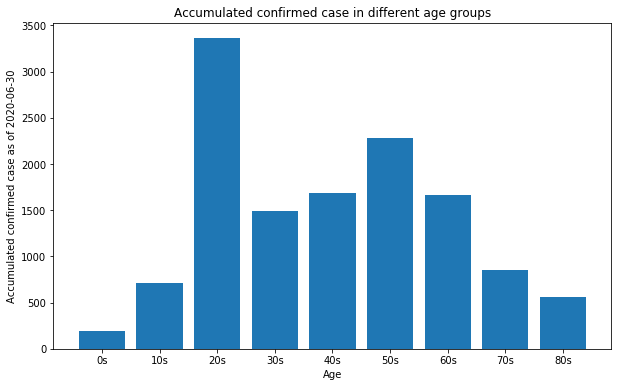

In [3]:
plt.figure(figsize = (10,6))
TimeAge = pd.read_csv('TimeAge.csv')
plt.bar(TimeAge[TimeAge.date == '2020-06-30']['age'],TimeAge[TimeAge.date == '2020-06-30']['confirmed'])
plt.xlabel('Age')
plt.ylabel('Accumulated confirmed case as of 2020-06-30')
plt.title('Accumulated confirmed case in different age groups')

We could see the 20s has the highest confirmed cases followed by 50s

But why the 20s, though...?

At first, I thought it might have something to do with their lifestyle. So in Korea, there's this thing called ‘Bul Geum,’ which is a word for representing a lifestyle among the younger generation where you enjoy nightlife every weekend, especially on Friday. Though, I am pretty sure there is a word for that in every other country.


To proceed with the analysis, I broke down the sources of infection for the 20s to see where they got the coronavirus the most

Text(0.5, 1.0, 'From which source did the 20s get the "Rona" the most?')

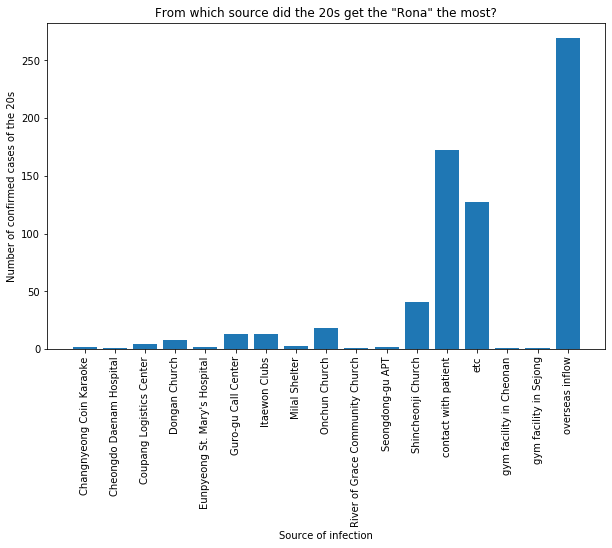

In [11]:
plt.figure(figsize=(10,6))
plt.bar(PatientInfo[PatientInfo.age == '20s'].groupby('infection_case').count()['patient_id'].index,
        PatientInfo[PatientInfo.age == '20s'].groupby('infection_case').count()['patient_id'])
plt.xticks(rotation = 90)
plt.xlabel('Source of infection')
plt.ylabel('Number of confirmed cases of the 20s')
plt.title('From which source did the 20s get the "Rona" the most?')

Hmm... this doesn't tell much I guess...

To gain further understanding, I broke down Seoul's floating population by age groups.

C:\Users\dy090\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


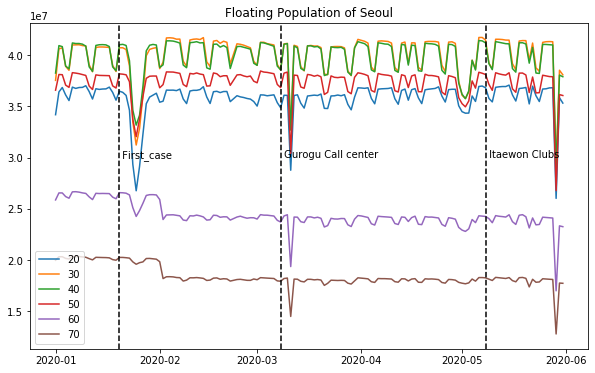

In [4]:
SeoulFloating = SeoulFloating[SeoulFloating.date != '2020-02-23'] # sorting out the noise
SB = SeoulFloating.groupby(['date','birth_year']).sum().reset_index()
SB.date = pd.to_datetime(SB.date)
by = SB.birth_year.unique()
plt.figure(figsize = (10,6))
for i in by:
    plt.plot(SB[SB.birth_year == i].date, SB[SB.birth_year == i].fp_num, label = i)
major_event = [pd.datetime(2020,1,20), pd.datetime(2020,3,8), pd.datetime(2020,5,8)]
major_event_text = [' First_case', ' Gurogu Call center', ' Itaewon Clubs']
for i in range(len(major_event)):
    plt.axvline(major_event[i], color = 'k', ls = '--')
    plt.annotate(major_event_text[i], xy = (major_event[i],30000000))
plt.title('Floating Population of Seoul')
plt.legend()

From the visualization, I found things like;
1. Floating population generally decreases on weekends.
2. There's a huge gap between the floating population of the 60s and 70s and that of the rest of the groups
3. Ever since the corona virus, the floating population of 60s and 70s had declined when there wasn't any trend in that of the rest of the groups
4. Between the age group of the 20s to 50s, it seems that the 20s and 50s' floating population has less gap between the weekdays and weekends, meaning that they are the ones that are relatively more active on weekends.

To mathematically measure the degree of gap between weekdays and weekends of each age group, I have calculated each group's floating population's standard deviation.

{20: 1649837.6794549678,
 30: 2041252.8382675091,
 40: 1898141.507092383,
 50: 1438199.4259757495,
 60: 1233844.7466128352,
 70: 1034540.1060866547}

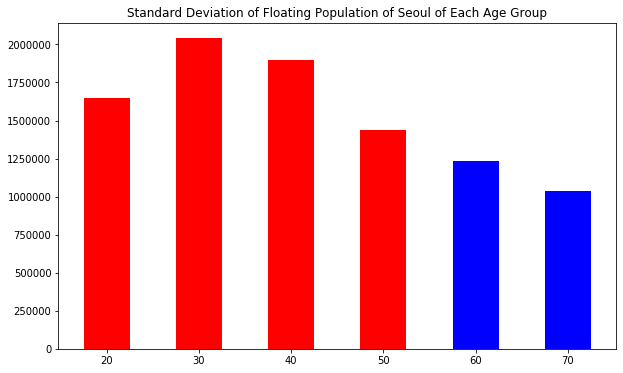

In [5]:
plt.figure(figsize = (10,6))
floating_std = {}
for i in by:
    floating_std[i] = SB[SB.birth_year == i].fp_num.std()

plt.bar(floating_std.keys(),floating_std.values(), width = 5, color = ['r']*4 + ['b']*2)
plt.title('Standard Deviation of Floating Population of Seoul of Each Age Group')
floating_std

So, it turns out that the 20s and 50s are more stable in terms of their floating population than the 30s and 40s. And they are the ones that have the higher confirmed cases. There might be a relation between the risk of getting the coronavirus and the lifestyle where you stay more active on weekends.

To do some further analysis, I decided to filter the cities that are famous for their nightlife facilities and the floating population of late hours to see if the 20s are actually enjoying their 'Bul Geum.'

Selected City:
- Gangnam-gu
- Mapo-gu
- Yongsan-gu

Selected hours:
- 23, 24, 0, 1, 2

In [6]:
import pandasql as ps
q1 = """
Select * from SeoulFloating
where city in ('Gangnam-gu', 'Mapo-gu', 'Yongsan-gu')
and hour in (23,24,0,1,2)
"""
nightlife_cities = ps.sqldf(q1, locals())
nightlife_cities

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Gangnam-gu,45680
1,2020-01-01,0,20,male,Seoul,Gangnam-gu,43680
2,2020-01-01,0,20,female,Seoul,Mapo-gu,39280
3,2020-01-01,0,20,male,Seoul,Mapo-gu,39820
4,2020-01-01,0,20,female,Seoul,Yongsan-gu,22320
...,...,...,...,...,...,...,...
21559,2020-05-25,23,60,male,Seoul,Mapo-gu,15510
21560,2020-05-26,1,20,male,Seoul,Yongsan-gu,15110
21561,2020-05-30,0,20,male,Seoul,Yongsan-gu,15720
21562,2020-05-31,0,20,male,Seoul,Mapo-gu,32610


Then, I have created the visualization that shows the average floating population of cities that are famous for their nightlife VS, that of average Seoul.

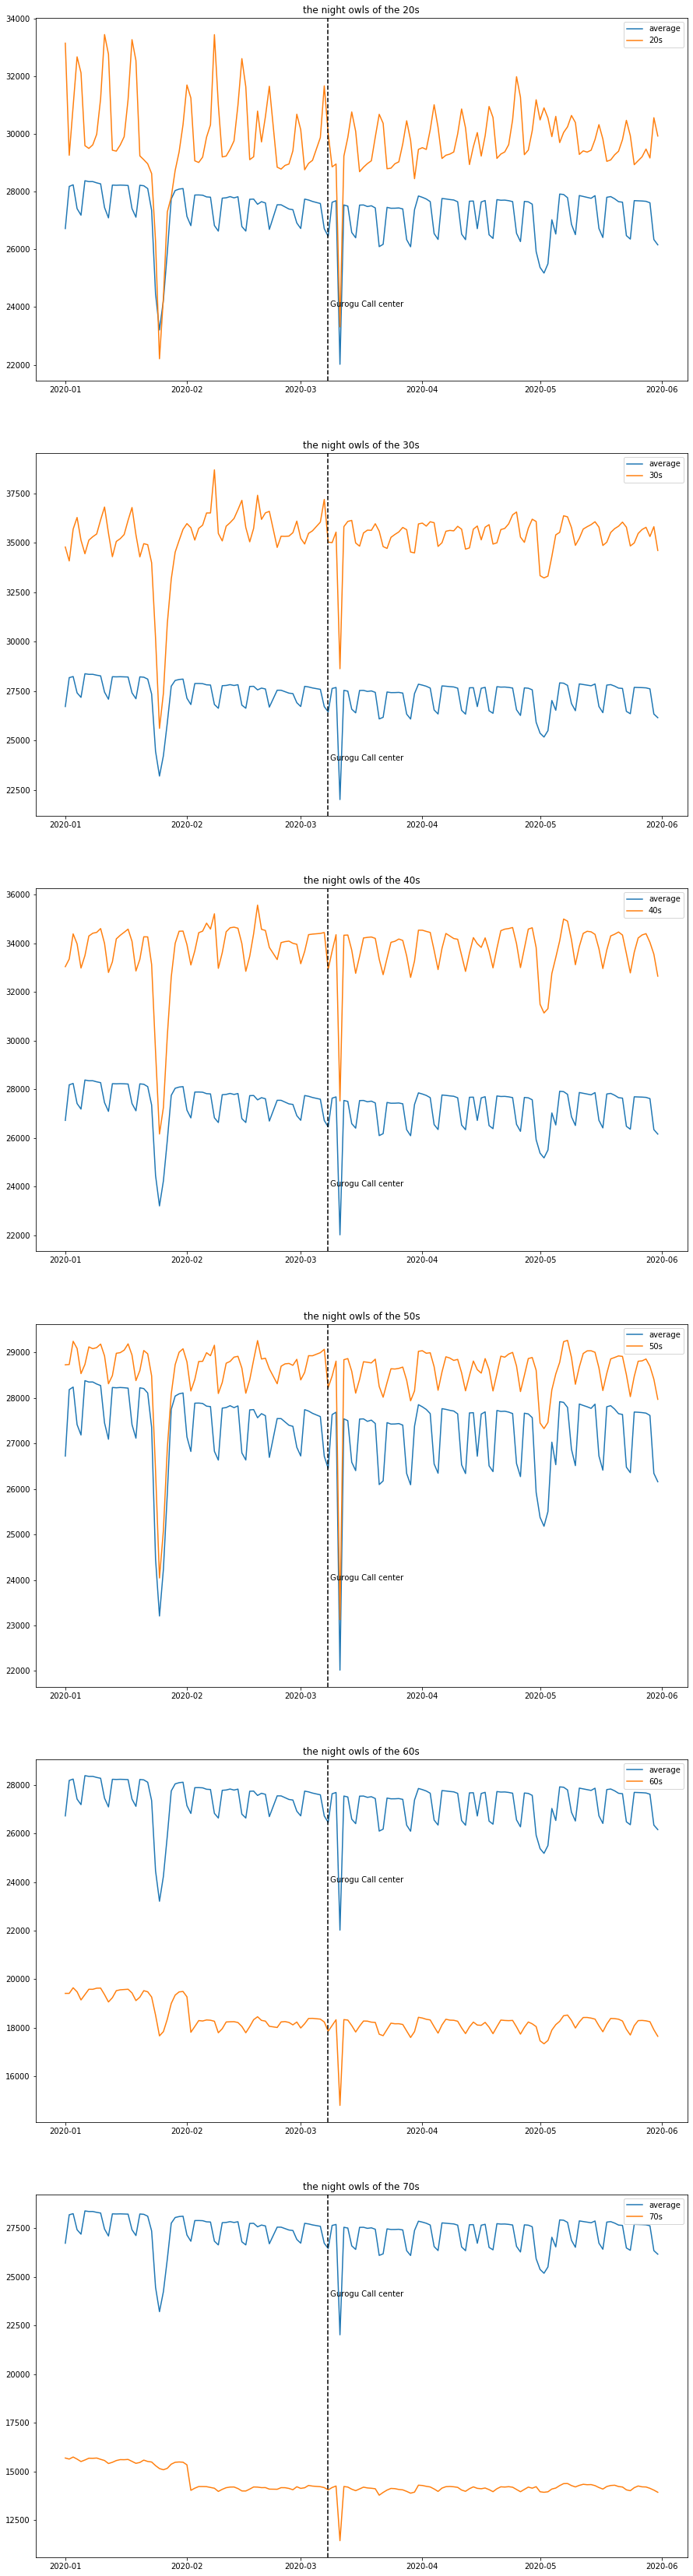

In [7]:
plt.figure(figsize = (15,60))
nightlife_cities.date = pd.to_datetime(nightlife_cities.date)
SeoulFloating.date = pd.to_datetime(SeoulFloating.date)
NSB = nightlife_cities.groupby(['date','birth_year']).mean().reset_index()
for i in range(6):
    plt.subplot(611 + i)
    plt.plot(SeoulFloating.groupby('date').mean().index, SeoulFloating.groupby('date').mean().fp_num, label = 'average')    
    plt.plot(NSB[NSB.birth_year == by[i]].date, NSB[NSB.birth_year == by[i]].fp_num, 
             label = '{}s'.format(by[i]))
    plt.title('the night owls of the {}s'.format(by[i]))
    plt.axvline(major_event[1], color = 'k', ls = '--')
    plt.annotate(major_event_text[1], xy = (major_event[1],24000))
    plt.legend()

Let's take a look at the visualization of the floating population of the 20s and 30s. Before the Guro-gu call center, both 20s and 30s enjoyed their nightlife on weekends. However, After the major outbreak, the floating population of the 30s had become somewhat identical with that of the rest of the group, while that wasn't the case in the 20s. The 20s were bold enough to carry on with their nightlife on weekends.

From the visualization, we can easily see that the floating population of the night owls of the 20s has pretty much the opposite trend than that of the average floating population.
To measure how different they are, I have created the correlation matrix.

In [8]:
NSB.pivot(index = 'date',columns = 'birth_year')['fp_num'].corr()
NSBXSF = pd.merge(NSB.pivot(index = 'date',columns = 'birth_year')['fp_num'], 
        SeoulFloating.groupby('date').mean(),
        how = 'inner',
        left_on = NSB.pivot(index = 'date',columns = 'birth_year')['fp_num'].index,
        right_on = SeoulFloating.groupby('date').mean().index)
NSBXSF.drop(['hour','birth_year'],axis =1, inplace=True)
NSBXSF.rename({'fp_num':'average'},axis = 1,inplace = True)
NSBXSF.set_index('key_0', inplace = True)
NSBXSF2 = NSBXSF.pct_change()
NSBXSF2.corr()

,20,30,40,50,60,70,average
20,1.000000,0.825165,0.549175,0.626281,0.510112,0.503373,0.175188
30,0.825165,1.000000,0.913886,0.913429,0.808014,0.705971,0.607775
40,0.549175,0.913886,1.000000,0.971377,0.919195,0.798282,0.839532
50,0.626281,0.913429,0.971377,1.000000,0.961877,0.891060,0.836436
60,0.510112,0.808014,0.919195,0.961877,1.000000,0.963633,0.845647
70,0.503373,0.705971,0.798282,0.891060,0.963633,1.000000,0.769359
average,0.175188,0.607775,0.839532,0.836436,0.845647,0.769359,1.000000


It is pretty obvious that the party people of 20s behave differently from other night owls. This might explain why the 20s have so many confirmed cases.

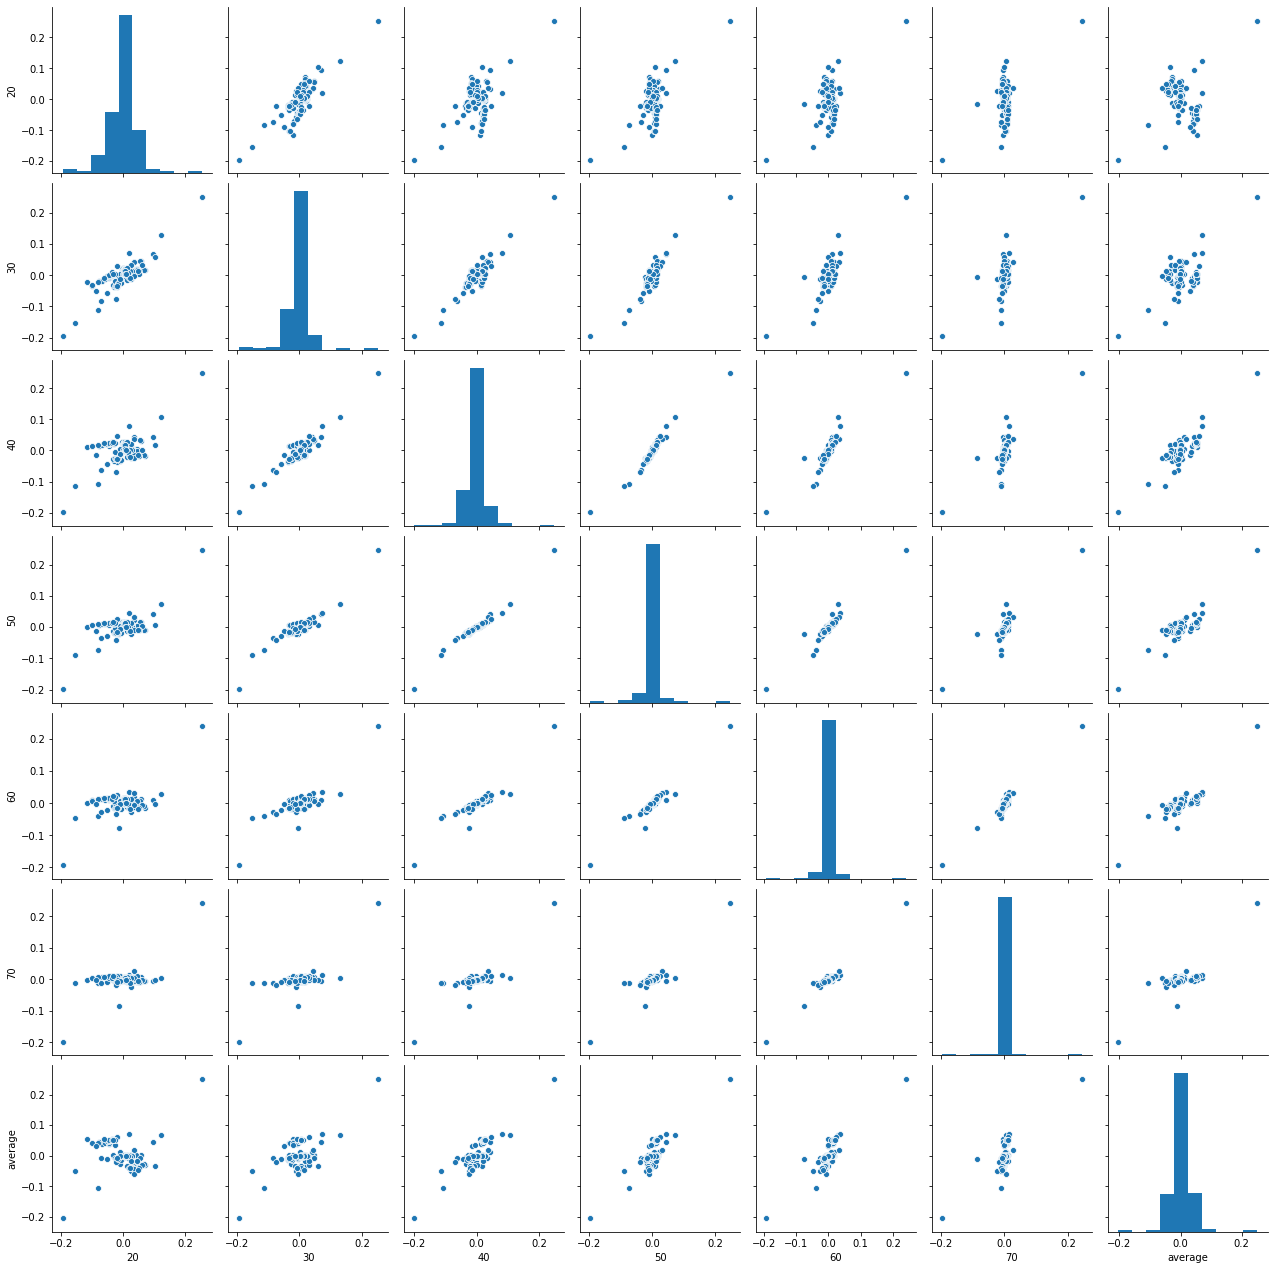

In [9]:
sns.pairplot(NSBXSF2)